In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_validate
from sklearn.model_selection import TimeSeriesSplit, cross_val_predict
import joblib

In [2]:
header = pd.read_csv('../data/All_Data.csv', nrows=0, encoding='ISO-8859-1')

dataset = pd.read_csv(
    '../data/All_Data.csv',
    header=None, 
    names=header.columns, 
    encoding='ISO-8859-1', 
    low_memory=False
)

In [3]:
dataset.isnull().sum()

Date                         0
Time                         0
Weekday                      0
Temperature                  0
Condition                    0
Humidity                     0
Wind_Speed                   0
Holiday                      0
Event                        0
Rainfall                     0
Solar_Generation             0
low_price                    0
high_price                   0
Average_Price_Rs_Per_Sqft    0
QoQ_Price_Change_Percent     0
Load                         0
BRPL                         0
BYPL                         0
NDPL                         0
NDMC                         0
MES                          0
dtype: int64

In [4]:
dataset['Load'] = pd.to_numeric(dataset['Load'], errors='coerce').fillna(0).astype(float)
dataset['Temperature'] = pd.to_numeric(dataset['Temperature'], errors='coerce').fillna(0).astype(float)
dataset['Humidity'] = pd.to_numeric(dataset['Humidity'], errors='coerce').fillna(0).astype(float)
dataset['Wind_Speed'] = pd.to_numeric(dataset['Wind_Speed'], errors='coerce').fillna(0).astype(float)
dataset['Holiday'] = pd.to_numeric(dataset['Holiday'], errors='coerce').fillna(0).astype(int)
dataset['Rainfall'] = pd.to_numeric(dataset['Rainfall'], errors='coerce').fillna(0).astype(float)
dataset['Solar_Generation'] = pd.to_numeric(dataset['Solar_Generation'], errors='coerce').fillna(0).astype(float)
dataset['low_price'] = pd.to_numeric(dataset['low_price'], errors='coerce').fillna(0).astype(float)
dataset['high_price'] = pd.to_numeric(dataset['high_price'], errors='coerce').fillna(0).astype(float)
dataset['Average_Price_Rs_Per_Sqft'] = pd.to_numeric(dataset['Average_Price_Rs_Per_Sqft'], errors='coerce').fillna(0).astype(float)
dataset['QoQ_Price_Change_Percent'] = pd.to_numeric(dataset['QoQ_Price_Change_Percent'], errors='coerce').fillna(0).astype(float)

In [5]:
dataset["Event"] = dataset["Event"].astype("category").cat.remove_unused_categories()
dataset = dataset[dataset['Load'] > 0]
print("Minimum Load Value:", dataset['Load'].min())
dataset = dataset.drop(['BRPL', 'BYPL', 'NDPL', 'NDMC', 'MES'], axis=1)

Minimum Load Value: 2297.49


In [6]:
dataset.dtypes

Date                           object
Time                           object
Weekday                        object
Temperature                   float64
Condition                      object
Humidity                      float64
Wind_Speed                    float64
Holiday                         int32
Event                        category
Rainfall                      float64
Solar_Generation              float64
low_price                     float64
high_price                    float64
Average_Price_Rs_Per_Sqft     float64
QoQ_Price_Change_Percent      float64
Load                          float64
dtype: object

In [7]:
# Convert dates and sort
dataset['Date'] = pd.to_datetime(dataset['Date'], format='%d-%m-%Y')
dataset.sort_values(['Date', 'Time'], inplace=True)

In [8]:
# Date/time features
dataset['Date'] = pd.to_datetime(dataset['Date'], format='%d-%m-%Y')
dataset['Day'] = dataset['Date'].dt.day
dataset['Month'] = dataset['Date'].dt.month
dataset['Year'] = dataset['Date'].dt.year
dataset['Weekday'] = dataset['Date'].dt.weekday
dataset['DayOfYear'] = dataset['Date'].dt.dayofyear
dataset['Hour'] = dataset['Time'].str.split('-').str[0].str[:2].astype(int)
dataset.sort_values(['Date', 'Hour'], inplace=True)

In [9]:
dataset.dtypes

Date                         datetime64[ns]
Time                                 object
Weekday                               int32
Temperature                         float64
Condition                            object
Humidity                            float64
Wind_Speed                          float64
Holiday                               int32
Event                              category
Rainfall                            float64
Solar_Generation                    float64
low_price                           float64
high_price                          float64
Average_Price_Rs_Per_Sqft           float64
QoQ_Price_Change_Percent            float64
Load                                float64
Day                                   int32
Month                                 int32
Year                                  int32
DayOfYear                             int32
Hour                                  int32
dtype: object

In [10]:
def encode_cyclical(df, col, max_val):
    df[f'{col}_sin'] = np.sin(2 * np.pi * df[col]/max_val)
    df[f'{col}_cos'] = np.cos(2 * np.pi * df[col]/max_val)
    return df

time_features = [('Hour', 24), ('Weekday', 7), ('Month', 12), ('DayOfYear', 365)]
for col, max_val in time_features:
    dataset = encode_cyclical(dataset, col, max_val)

In [ ]:
lags = [1, 6, 24, 168]
for lag in lags:
    dataset[f'load_lag_{lag}h'] = dataset['Load'].shift(lag)
    
dataset['7d_ma_load'] = dataset['Load'].rolling(168).mean()

# Final cleaning
dataset.dropna(inplace=True)

In [17]:
dataset['temp_x_hour'] = dataset['Temperature'] * dataset['Hour']
cyclical_cols = [f'{col}_{trig}' for col, _ in time_features for trig in ['sin', 'cos']]
categorical_features = ['Condition', 'Holiday', 'Event']
numerical_features = [
    'Temperature', 'Humidity', 'Wind_Speed',
    'Rainfall', 'Solar_Generation', 'low_price', 'high_price',
    'Average_Price_Rs_Per_Sqft', 'QoQ_Price_Change_Percent', 'temp_x_hour'
]

In [18]:
dataset.dtypes

Date                         datetime64[ns]
Time                                 object
Weekday                               int32
Temperature                         float64
Condition                            object
Humidity                            float64
Wind_Speed                          float64
Holiday                               int32
Event                              category
Rainfall                            float64
Solar_Generation                    float64
low_price                           float64
high_price                          float64
Average_Price_Rs_Per_Sqft           float64
QoQ_Price_Change_Percent            float64
Load                                float64
Day                                   int32
Month                                 int32
Year                                  int32
DayOfYear                             int32
Hour                                  int32
Hour_sin                            float64
Hour_cos                        

In [19]:
X = dataset.drop(columns=['Load', 'Date', 'Time'])
y = dataset['Load']

In [20]:
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='infrequent_if_exist', sparse_output=False), 
     categorical_features),
    ('num', 'passthrough', numerical_features + cyclical_cols)
])

In [21]:
final_model = Pipeline([
    ('preprocessor', preprocessor),
    ('model', TransformedTargetRegressor(
        regressor=RandomForestRegressor(
            n_estimators=200,
            max_depth=15,
            min_samples_split=10,
            max_features=0.7,
            max_samples=0.8,
            random_state=42,
            n_jobs=-1
        ),
        func=np.log,
        inverse_func=np.exp
    ))
])

In [22]:
final_model.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                sparse_output=False),
                                                  ['Condition', 'Holiday',
                                                   'Event']),
                                                 ('num', 'passthrough',
                                                  ['Temperature', 'Humidity',
                                                   'Wind_Speed', 'Rainfall',
                                                   'Solar_Generation',
                                                   'low_price', 'high_price',
                                                   'Average_Price_Rs_Per_Sqft',
                                                   'QoQ_Price_Change_Percent',
                                                   'temp_x_hour', 'Hour_sin',
                                                   'Hour_cos', 'Weekday_sin',
                                                   'Weekday_cos', 'Month_sin',
                                                   'Month_cos', 'DayOfYear_sin',
                                                   'DayOfYear_cos'])])),
                ('model',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=RandomForestRegressor(max_depth=15,
                                                                            max_features=0.7,
                                                                            max_samples=0.8,
                                                                            min_samples_split=10,
                                                                            n_estimators=200,
                                                                            n_jobs=-1,
                                                                            random_state=42)))])

In [23]:
joblib.dump(final_model, "../model2.pkl")

['../model2.pkl']

In [32]:
# 1. Cross-Validation Metrics
cv_results = cross_validate(
    final_model,
    X, y,
    cv=5,
    scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'],
    n_jobs=-1,
    return_train_score=True
)

print(f"Average CV RMSE: {np.sqrt(-cv_results['test_neg_mean_squared_error']).mean():.2f}")
print(f"Average CV MAE: {-cv_results['test_neg_mean_absolute_error'].mean():.2f}")
print(f"Average CV R²: {cv_results['test_r2'].mean():.2f}")

# Compare train vs validation scores
print(f"\nTrain R²: {cv_results['train_r2'].mean():.2f} vs Validation R²: {cv_results['test_r2'].mean():.2f}")

Average CV RMSE: 2409.40
Average CV MAE: 1202.80
Average CV R²: 0.97

Train R²: 0.99 vs Validation R²: 0.97


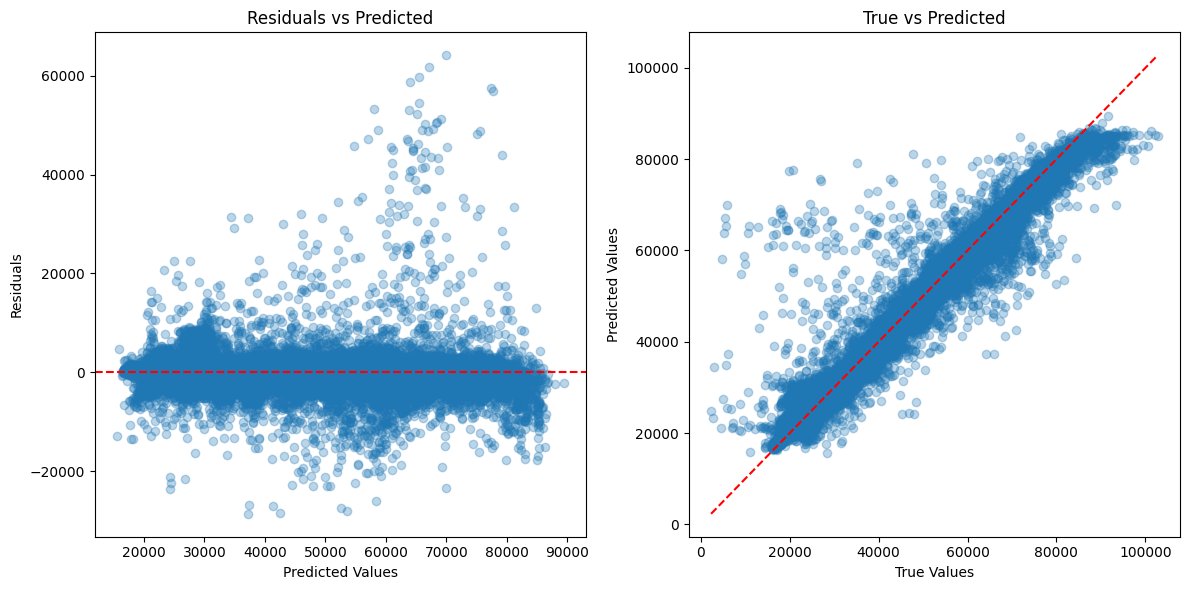

In [33]:
# 2. Residual Analysis
# Get cross-validated predictions
y_pred = cross_val_predict(final_model, X, y, cv=5, n_jobs=-1)

# Residual plots
plt.figure(figsize=(12, 6))

# Residuals vs Predicted
plt.subplot(1, 2, 1)
plt.scatter(y_pred, y_pred - y, alpha=0.3)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted")

# Prediction accuracy
plt.subplot(1, 2, 2)
plt.scatter(y, y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted")

plt.tight_layout()
plt.show()

In [34]:
# 3. Temporal Validation

# Assuming data is sorted by date
tscv = TimeSeriesSplit(n_splits=5)
time_cv_scores = cross_validate(
    final_model,
    X, y,
    cv=tscv,
    scoring=['neg_mean_squared_error', 'r2'],
    n_jobs=-1
)

print(f"Time Series CV RMSE: {np.sqrt(-time_cv_scores['test_neg_mean_squared_error'])}")
print(f"Time Series R²: {time_cv_scores['test_r2']}")

Time Series CV RMSE: [1525.57777388 1800.70351588 3759.29656635 3721.44693399 3469.16532671]
Time Series R²: [0.98960812 0.98013809 0.93612414 0.93859195 0.95702732]


In [35]:
# 4. Feature Importance Validation
feature_names = final_model.named_steps['preprocessor'].get_feature_names_out()
importances = final_model.named_steps['model'].regressor_.feature_importances_

print("=== Top 10 Features ===")
top_features = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(10)
print(top_features)

=== Top 10 Features ===
num__load_lag_1h      0.621725
num__load_lag_24h     0.280001
num__7d_ma_load       0.039232
num__Hour_cos         0.013869
num__temp_x_hour      0.011266
num__load_lag_168h    0.009334
num__Hour_sin         0.005087
num__load_lag_6h      0.004367
num__Temperature      0.002897
num__DayOfYear_cos    0.002658
dtype: float64


In [36]:
# 5. Business Logic Checks
print("=== Business Validation ===")
# Check negative predictions
predictions = final_model.predict(X)
print(f"Negative Predictions: {(predictions < 0).sum()} (should be 0)")

# Sample inspection
sample = X.sample(5)
print("\nSample Predictions:")
print(pd.DataFrame({
    'Predicted': final_model.predict(sample),
    'Actual': y.loc[sample.index],
    'Difference (%)': np.abs((final_model.predict(sample) - y.loc[sample.index])/y.loc[sample.index])*100
}))

=== Business Validation ===
Negative Predictions: 0 (should be 0)

Sample Predictions:
           Predicted    Actual  Difference (%)
87907   42217.086908  42883.81        1.554720
133808  42812.303625  42962.32        0.349181
110162  62865.715102  62153.74        1.145506
129398  61363.757606  64513.08        4.881680
124332  48747.039043  47863.55        1.845849


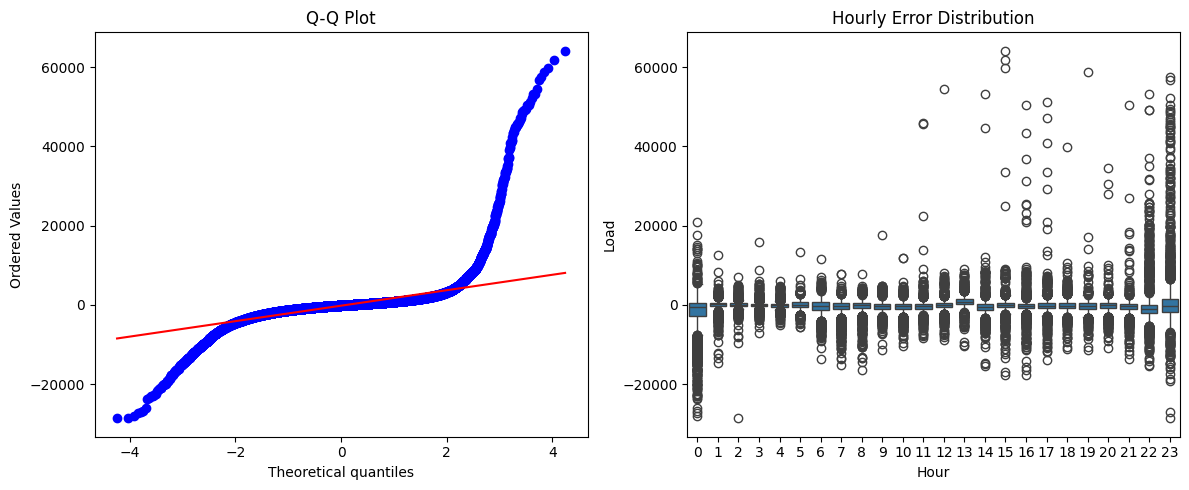

In [37]:
# 6. Error Distribution Analysis
from scipy import stats
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
stats.probplot(y_pred - y, dist="norm", plot=plt)
plt.title('Q-Q Plot')

plt.subplot(1, 2, 2)
sns.boxplot(x=dataset['Hour'], y=y_pred - y)
plt.title('Hourly Error Distribution')
plt.tight_layout()
plt.show()

In [38]:
X.head()

,Weekday,Temperature,Condition,Humidity,Wind_Speed,Holiday,Event,Rainfall,Solar_Generation,low_price,...,Month_sin,Month_cos,DayOfYear_sin,DayOfYear_cos,load_lag_1h,load_lag_6h,load_lag_24h,load_lag_168h,7d_ma_load,temp_x_hour
70298,0,6.0,Fog,97.0,0.0,0,No,0.006452,0.001384,2747.0,...,0.5,0.866025,0.137279,0.990532,21948.14,38223.25,19389.74,20905.32,33674.793750,6.0
70299,0,6.0,Fog,97.0,0.0,0,No,0.006452,0.001384,2747.0,...,0.5,0.866025,0.137279,0.990532,19622.08,36253.58,18305.83,18827.25,33669.219405,12.0
70300,0,6.0,Fog,97.0,2.0,0,No,0.006452,0.001384,2747.0,...,0.5,0.866025,0.137279,0.990532,17890.76,34189.77,17793.54,17624.49,33669.412619,18.0
70301,0,6.0,Fog,97.0,2.0,0,No,0.006452,0.001384,2747.0,...,0.5,0.866025,0.137279,0.990532,17656.95,30932.84,18415.54,17092.84,33677.462440,24.0
70302,0,6.0,Fog,97.0,2.0,0,No,0.006452,0.001384,2747.0,...,0.5,0.866025,0.137279,0.990532,18445.21,26599.69,21121.66,17661.66,33705.580000,30.0


In [39]:
X.columns.shape

(32,)

In [40]:
X.columns[22:]

Index(['Month_sin', 'Month_cos', 'DayOfYear_sin', 'DayOfYear_cos',
       'load_lag_1h', 'load_lag_6h', 'load_lag_24h', 'load_lag_168h',
       '7d_ma_load', 'temp_x_hour'],
      dtype='object')

In [41]:
for i in X.columns:
    print(i)

Weekday
Temperature
Condition
Humidity
Wind_Speed
Holiday
Event
Rainfall
Solar_Generation
low_price
high_price
Average_Price_Rs_Per_Sqft
QoQ_Price_Change_Percent
Day
Month
Year
DayOfYear
Hour
Hour_sin
Hour_cos
Weekday_sin
Weekday_cos
Month_sin
Month_cos
DayOfYear_sin
DayOfYear_cos
load_lag_1h
load_lag_6h
load_lag_24h
load_lag_168h
7d_ma_load
temp_x_hour
